In [3]:
import numpy as np
import pandas as pd
import pandas_profiling
import math
import re
import sklearn
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from spellchecker import SpellChecker
from word2number import w2n
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from datetime import datetime

In [4]:
def is_number(s):
    """ Returns True is string is a number. """
    try:
        float(s)
        return True
    except ValueError:
        return False

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train["stroke_in_2018"]=train["stroke_in_2018"].apply(lambda x: x if x in ["0","1"] else None)
train = train[pd.notnull(train['stroke_in_2018'])] # Remove if target is NULL
y_train = train["stroke_in_2018"]
print("Training ",train.shape)
spell = SpellChecker()

Training  (34831, 14)


### Merge Duplicate data in train

In [6]:
def merge(grp):
    df = pd.DataFrame()
    if(grp.shape[0] > 1):
        for c in grp.columns:
            value_counts = grp[c].value_counts().index.astype(grp[c].dtypes)
            if value_counts.size > 1:
                print(grp, value_counts) #Error
            elif value_counts.size == 1:
                df[c] = value_counts[0]
            else:
                df[c] = None
    else:
        df = grp.head(1)
    return df
train = train.groupby("id").apply(merge)

In [7]:
ntrain = y_train.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['stroke_in_2018'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (43319, 13)


E:\Program\Anaconda\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [8]:
print(ntrain)

34831


### Data Cleaning

In [9]:
def is_job_status_and_living_area_reversed(x):
    return ((x["job_status"] != None and x["job_status"] in ("r", "c", "city", "remote", "remotee"))
             or (x["living_area"] != None and x["living_area"] in ("private_sector", "business_owner")))
def process_job_status(x):
    if x == None or x in ("nan", 'null', "", 'n.a'):
        return None
    elif x in ("private sector", "privattte", "private", "private_sector"):
        return "private_sector"
    elif x in ("government", "govt."):
        return "government"
    elif x in ("business_owner", "business owner", "biz"):
        return "business_owner"
    elif x in ("parental_leave", "parental leave"):
        return "parental_leave"
    else:
        return x
    
def process_living_area(x):
    if x == None or x in ("nan", 'null', "", 'n.a'):
        return None
    elif x == 'c':
        return 'city'
    elif x in ('r', 'remotee'):
        return 'remote'
    else:
        return x

def split_job_status_and_living_area(x):
    pair = x.lower().split("?") if x != None else [x, x]
    if len(pair) < 2:
        pair = [pair[0], None]
    return pair

def process_job_status_and_living_area(df):
    df["job_status"] = df["job_status and living_area"].astype(str).apply(split_job_status_and_living_area).apply(lambda x: x[0])
    df["living_area"] = df["job_status and living_area"].astype(str).apply(split_job_status_and_living_area).apply(lambda x: x[1])
    job_status = df.apply(lambda x: x["living_area"] if is_job_status_and_living_area_reversed(x) else x["job_status"], 1)
    living_area = df.apply(lambda x: x["job_status"] if is_job_status_and_living_area_reversed(x) else x["living_area"], 1)
    df["job_status"] = job_status.apply(lambda x: process_job_status(x))
    df["living_area"] = living_area.apply(lambda x: process_living_area(x))
    df.drop(columns='job_status and living_area',inplace=True)

In [10]:
process_job_status_and_living_area(all_data)
#process_job_status_and_living_area(test)

In [11]:
def process_smoker_status(x):
    if x == None:
        return None
    elif x.startswith("non"):
        return "non-smoker"
    elif x.startswith("quit"):
        return "quit"
    elif x.startswith("active"):
        return "active_smoker"
    else:
        return None
all_data["smoker_status"] = all_data["smoker_status"].astype(str).apply(process_smoker_status)
#test["smoker_status"] = test["smoker_status"].astype(str).apply(process_smoker_status)

In [12]:
def process_binary_col(df,columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col],errors="coerce")
        df[col] = df[col].astype(int,errors='ignore')
        df[col] = df[col].apply(lambda x: x if x in [0,1] else None)

In [13]:
process_binary_col(all_data,["heart_condition_detected_2017","high_BP","married"])

Convert BMI to numeric

In [14]:
all_data["BMI"] = pd.to_numeric(all_data["BMI"],errors="coerce")

In [15]:
# Process gender into oneof "F", "M" and "OTHER"
def genderSpellingRewrite(gender_str):
    if not isinstance(gender_str, str):
        return None;
    uppered = gender_str.upper()
    # Repeated single occurence should be truncate.
    patternM = re.compile('[M]+$')
    if (patternM.match(uppered)):
        return "M"
    patternF = re.compile('[F]+$')
    if (patternF.match(uppered)):
        return "F"
    # Misspelling should be corrected and replaced.
    # TODO: Malle is not going to be corrected as Male.Need to update spell's known list.
    corrected = spell.correction(uppered).upper()
    if (corrected == "FEMALE"):
        return "F"
    if (corrected == "MALE"):
        return "M"
    if (corrected == "OTHER"):
        return "OTHER"
    return None

In [16]:
# Process human number word into number
def numberConversion(potential_number_word):
    # Correct any possible miss spelled number_word
    corrected_potential_word = spell.correction(potential_number_word)
    # check it it means number
    try:
      potential_num = w2n.word_to_num(corrected_potential_word)
    except ValueError:
        return potential_number_word
    return potential_num

In [17]:
def formatSexAge(origin_str):
    if not isinstance(origin_str, str):
        return [None,None]
    # Preprocess 
    # Entry with missing column.
    if (',' not in origin_str):
        origin_str = origin_str + ',';
    origin_list = origin_str.replace(" ", "").upper().split(",")
    if(origin_list[0].upper() == "NAN"):
        origin_list[0] = ""
    if(origin_list[1].upper() == "NAN"):
        origin_list[1] = ""
    # Convert possible number in entry.
    if((not is_number(origin_list[0])) and (not is_number(origin_list[1]))):
        origin_list[0] = numberConversion(origin_list[0])
        origin_list[1] = numberConversion(origin_list[1])
    genderSet = set(['F', 'M', 'OTHER'])
    if (is_number(origin_list[0])):
        # wrong entry (num, num)
        if (is_number(origin_list[1])):
            if (origin_list[0] == origin_list[1]):
                return [None, origin_list[0]]
            return [None, None]
        else: # first number, second '' or gender (NOT num for sure)
          # swap back number
          origin_list = origin_list[::-1]
          origin_list[0] = genderSpellingRewrite(origin_list[0])
          return origin_list
    else: 
        origin_list[0] = genderSpellingRewrite(origin_list[0])
         # first '' or str, second is number
        if (is_number(origin_list[1])):
            return origin_list
        else:
            origin_list[1] = genderSpellingRewrite(origin_list[1])
            if(origin_list[0] == origin_list[1]):
               origin_list[1] = None
            return origin_list

In [18]:
list(all_data)

['BMI',
 'TreatmentA',
 'TreatmentB',
 'TreatmentC',
 'TreatmentD',
 'average_blood_sugar',
 'heart_condition_detected_2017',
 'high_BP',
 'id',
 'married',
 'sex and age',
 'smoker_status',
 'job_status',
 'living_area']

In [19]:
def process_sex_age_(df):
    df["sex_age_list"] = df["sex and age"].astype(str).apply(lambda x: formatSexAge(x))
    df[['sex','age']] = pd.DataFrame(df["sex_age_list"].values.tolist(), index= df.index)
    df[df["sex"] == "None"]["sex"] = "OTHER"
process_sex_age_(all_data)

Clean Sex and Age

In [20]:
# def clean_sex_age(sex_age_list):
#     if type(sex_age_list) is not list:
#         return [None,None]
#     # Strip and Upper case both sex and age
#     sex_age_list[0],sex_age_list[1] = sex_age_list[0].strip().upper(), sex_age_list[1].strip().upper()
    
#     # 2nd : first one is empty and second one is not numeric
#     if (is_number(sex_age_list[0]) or (not sex_age_list[0] and not is_number(sex_age_list[1]))): 
#         sex_age_list = sex_age_list[::-1]
#     sex = sex_age_list[0].strip().upper()
    
#     if sex in ('FEMALE','FEMALLE'):
#         sex = 'F'
#     if sex in ('MALE','MMALE','MM'):
#         sex = 'M'

#     sex_age_list[0] = sex
#     sex_age_list[1] = sex_age_list[1]
#     return sex_age_list

# def process_sex_age(df):
#     df["sex_age_list"] = df["sex and age"].str.split(",").apply(clean_sex_age)
#     df[['sex','age']] = pd.DataFrame(df["sex_age_list"].values.tolist(), index= df.index)
#     df["age"] = pd.to_numeric(df["age"],errors='coerce').round()
#     return df.drop(columns=["sex_age_list","sex and age"])
# all_data = process_sex_age(all_data)

In [21]:
all_data["age"] = pd.to_numeric(all_data["age"],errors="coerce")

In [22]:
def split_train_test(df):
    return df[:ntrain], df[ntrain:]

In [23]:
preprocessed_train, preprocessed_test = split_train_test(all_data)

In [24]:
def convert_to_categorical(df, columns):
    for col in columns:
        df[col] = df[col].astype(str)

### Missing Values

In [25]:
def impute_by_mode(df,columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mode().iloc[0])
def impute_by_median(df,columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].median())

In [26]:
impute_by_mode(all_data,["heart_condition_detected_2017","high_BP","married","job_status"])
impute_by_median(all_data,["average_blood_sugar"])

In [27]:
all_data["sex"] = all_data["sex"].fillna("OTHER")

Impute Age by Median group by sex

In [28]:
df_tmp = preprocessed_train.groupby("sex")["age"].median().reset_index(name="MedianAge")
df_merge = all_data.merge(df_tmp,on="sex",how="left")
cond = df_merge['age'].isnull()
df_merge['age'] = df_merge['age'].fillna(df_merge["MedianAge"])
all_data = df_merge.drop(columns="MedianAge")

Check missing value of smoker_status

In [29]:
convert_to_categorical(all_data,["heart_condition_detected_2017","married","high_BP","job_status",
                                 "sex","living_area"])
preprocessed_train, preprocessed_test = split_train_test(all_data)

In [30]:
def predict_missing(df,missing_var,independent_var,model):
    selected_cols = independent_var+[missing_var]
    non_missing_data = df[df[missing_var].notnull()][selected_cols]
    # Remove missing values
    non_missing_data = non_missing_data.dropna()
    print("Training data for missing value ",non_missing_data.shape)
    
    # Build Random Forest classifier
    clf = make_pipeline(OneHotEncoder(handle_unknown="ignore"),model)
    clf.fit(non_missing_data[independent_var],non_missing_data[missing_var])
    acc = np.mean(cross_val_score(clf,non_missing_data[independent_var],non_missing_data[missing_var],cv=5))
    print("Random Forest Mean Accuracy for 5 runs of cross validation ", acc)
    
    # Predict missing values
    cond = df[missing_var].isnull()
    df[cond][missing_var] = clf.predict(df[cond][independent_var])
    return clf

In [31]:
clf = predict_missing(all_data,"smoker_status",["age","sex","married","high_BP","living_area","average_blood_sugar"],
                        RandomForestClassifier(n_estimators=600, max_depth=7))
# clf = rf_predict_missing(all_data,"",["BMI","age","sex","high_BP","married"])

Training data for missing value  (30050, 7)
Random Forest Mean Accuracy for 5 runs of cross validation  0.5331780432475773


E:\Program\Anaconda\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [32]:
#impute_by_median(all_data,["BMI"])

In [33]:
def bmi_category(bmi):
    if pd.isnull(bmi):
        return np.nan
    if bmi > 35:
        return "SO"
    elif bmi > 30:
        return "MO"
    elif bmi > 25:
        return "O"
    elif bmi > 18.5:
        return "N"
    else:
        return "U"

all_data["bmi_category"] = all_data["BMI"].apply(bmi_category)
predict_missing(all_data,"bmi_category", ["job_status", "high_BP", "heart_condition_detected_2017",
                                             "married", "age", "sex", "average_blood_sugar"],AdaBoostClassifier())

Training data for missing value  (41853, 8)
Random Forest Mean Accuracy for 5 runs of cross validation  0.3803788277146635


E:\Program\Anaconda\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=None, dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', n_values=None,
                               sparse=True)),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=50,
                                    random_state=None))],
         verbose=False)

In [34]:
selected_vars = ["sex","age","high_BP","heart_condition_detected_2017",
                "married","job_status","living_area","average_blood_sugar",
                "bmi_category","smoker_status"]
selected_data = all_data[selected_vars]
selected_data = pd.get_dummies(selected_data).reset_index(drop=True)

In [35]:
X_train = selected_data[:ntrain]
X_test = selected_data[ntrain:]
print("Training data ",X_train.shape, " target ",y_train.shape)
print("Testing data", X_test.shape)

Training data  (34831, 27)  target  (34831,)
Testing data (8488, 27)


Explore Data Complexity

In [36]:
def plot2D(X,y):
    df_tsne = pd.DataFrame()
    df_tsne['stroke'] = y
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=3000)
    tsne_results = tsne.fit_transform(X)
    df_tsne['tsne_v1'] = tsne_results[:,0]
    df_tsne['tsne_v2'] = tsne_results[:,1]
    # Make the plot
    sns.scatterplot(
        x="tsne_v1", y="tsne_v2",
        hue="stroke",
        palette=sns.hls_palette(2, l=.3, s=.9),
        data=df_tsne,
        legend="full",
        alpha=0.3
    )

In [37]:
# tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=3000)
# tsne_results = tsne.fit_transform(X_train)

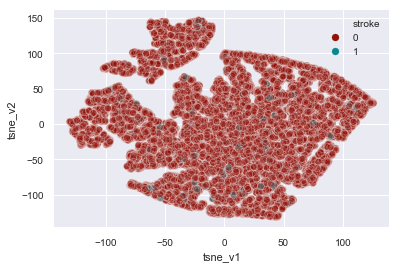

In [52]:
df_tsne['tsne_v1'] = tsne_results[:,0]
df_tsne['tsne_v2'] = tsne_results[:,1]
# Make the plot
sns.scatterplot(
    x="tsne_v1", y="tsne_v2",
    hue="stroke",
    palette=sns.hls_palette(2, l=.3, s=.9),
    data=df_tsne,
    legend="full",
    alpha=0.3
)

In [544]:
profile = all_data.profile_report(title='Medical Record Profiling Report')
profile.to_file(output_file="train_data_summary.html")

E:\Program\Anaconda\envs\NLP\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
E:\Program\Anaconda\envs\NLP\lib\site-packages\pandas\core\internals.py:389: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.values = np.delete(self.values, loc, 0)
E:\Program\Anaconda\envs\NLP\lib\site-packages\pandas\core\internals.py:390: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  self.mgr_locs = self.mgr_locs.delete(loc)


AssertionError: Gaps in blk ref_locs

In [40]:
y_train.value_counts()

0    34179
1      652
Name: stroke_in_2018, dtype: int64

# MODEL

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={"0": 4000})
X_cc, y_cc = cc.fit_sample(X_train, y_train)

#plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

In [128]:
print('START ML', datetime.now(), )
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def grid_search(X_train,y_train,model,param_grid,scoring=["precision","accuracy"],refit="precision"):
    gs = GridSearchCV(model,param_grid=params,scoring=scoring,refit=refit,cv=kfolds)
    gs.fit(X_train,y_train)
    results = gs.cv_results_
    print(refit," =",gs.best_score_," achieved by configuration : ",gs.best_params_)
    best_idx = np.argwhere(results['rank_test_%s' % refit] == 1)[0,0]
    for scorer in scoring:
        for sample in ('train','test'):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)][best_idx]
            print(sample,"_",scorer,":",sample_score_mean)
    return gs

START ML 2019-07-21 00:39:49.141888


In [129]:
svm = Pipeline([
            ('rs',RobustScaler()),
            ('svm',SVC(random_state=0,kernel='rbf',class_weight="balanced"))
        ])
params = {"svm__C":np.logspace(-4, 4, num=10, base=2)}
gs_svm = grid_search(X_cc,y_cc,svm,params)

E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precisi

E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy  = 0.9809939421779449  achieved by configuration :  {'svm__C': 8.640477911138447}
train _ accuracy : 0.9810130811152435
test _ accuracy : 0.9809939421779449
train _ precision : 0.0061583577712609975
test _ precision : 0.0


E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\Program\Anaconda\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [ ]:
cvres = gs_svm.cv_results_
test_score = cvres["mean_test_score"]
train_score = cvres["mean_train_score"]
plt.plot(alpha,test_score,label="test_score")
plt.plot(alpha,train_score,label="train_score")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('r2 score')